# XAI Tutorial 2: Instance Tracking

## Overview
In this tutorial, we will discuss the following topics:
* [Instance Tracking](#tx02instance)

We'll start by getting the imports out of the way:

In [1]:
import tempfile
import os

import tensorflow as tf

import fastestimator as fe
from fastestimator.architecture.tensorflow import LeNet
from fastestimator.backend import squeeze, reduce_mean
from fastestimator.dataset.data import cifair10
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, PadIfNeeded, RandomCrop
from fastestimator.op.numpyop.univariate import CoarseDropout, Normalize
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver, ImageViewer
from fastestimator.trace.metric import MCC
from fastestimator.trace.xai import InstanceTracker
from fastestimator.util import to_number


import matplotlib.pyplot as plt
import numpy as np

label_mapping = {
    'airplane': 0,
    'automobile': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9
}

<a id='tx02instance'></a>

## Instance Tracking

Suppose you are doing some training, and you want to know which samples from your dataset are the most difficult to learn. Perhaps they were mislabeled, for example. Let's suppose you're also very curious about how well sample 10 and sample 18 from your training data do over time. One way to investigate this is with the `InstanceTracker` `Trace`. It takes as input any per-element metric (such as sample-wise loss), as well as an index vector and produces a visualization at the end of training:

In [2]:
batch_size=128
save_dir = tempfile.mkdtemp()

train_data, eval_data = cifair10.load_data()
test_data = eval_data.split(range(len(eval_data) // 2))

train_data['index'] = np.array([i for i in range(len(train_data))], dtype=np.int).reshape((len(train_data), 1))

pipeline = fe.Pipeline(
    train_data=train_data,
    eval_data=eval_data,
    test_data=test_data,
    batch_size=batch_size,
    ops=[Normalize(inputs="x", outputs="x", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)),
         PadIfNeeded(min_height=40, min_width=40, image_in="x", image_out="x", mode="train"),
         RandomCrop(32, 32, image_in="x", image_out="x", mode="train"),
         Sometimes(HorizontalFlip(image_in="x", image_out="x", mode="train")),
         CoarseDropout(inputs="x", outputs="x", mode="train", max_holes=1),
         ],
    num_process=0)

model = fe.build(model_fn=lambda: LeNet(input_shape=(32, 32, 3)), optimizer_fn="adam")
network = fe.Network(ops=[
    ModelOp(model=model, inputs="x", outputs="y_pred"),
    CrossEntropy(inputs=("y_pred", "y"), outputs="sample_ce", average_loss=False),
    LambdaOp(inputs="sample_ce", outputs="ce", fn=lambda x: reduce_mean(x)),
    UpdateOp(model=model, loss_name="ce")
])

traces = [
    MCC(true_key="y", pred_key="y_pred"),
    BestModelSaver(model=model, save_dir=save_dir, metric="mcc", save_best_mode="max", load_best_final=True),
    InstanceTracker(index="index", metric="sample_ce", n_max_to_keep=5, n_min_to_keep=0, list_to_keep=[10, 18], outputs="ce_vs_idx", mode="train"),
    ImageViewer(inputs="ce_vs_idx", mode="train")
]
estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=10,
                         traces=traces,
                         log_steps=300)

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 300; num_device: 0;
FastEstimator-Train: step: 1; ce: 2.332996;
FastEstimator-Train: step: 300; ce: 1.2636817; steps/sec: 14.73;
FastEstimator-Train: step: 391; epoch: 1; epoch_time: 28.77 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/3r/h9kh47050gv6rbt_pgf8cl540000gn/T/tmpjj0pxuin/model_best_mcc.h5
FastEstimator-Eval: step: 391; epoch: 1; ce: 1.3300469; max_mcc: 0.46148605704461154; mcc: 0.46148605704461154; since_best_mcc: 0;
FastEstimator-Train: step: 600; ce: 1.2777663; steps/sec: 13.19;

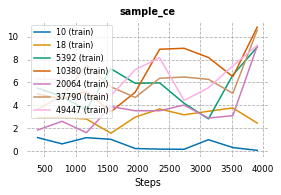

FastEstimator-Finish: step: 3910; model_lr: 0.001; total_time: 327.6 sec;


In [3]:
estimator.fit()

From the graph above it looks like datapoint number 10 is pretty easy, whereas 18 is somewhat difficult. Performance on some of the hardest points actually seems to get worse over time, so perhaps it would be worth visualizing them to see if there's a reason the network is having a hard time. Let's take a look at 10380, for example:

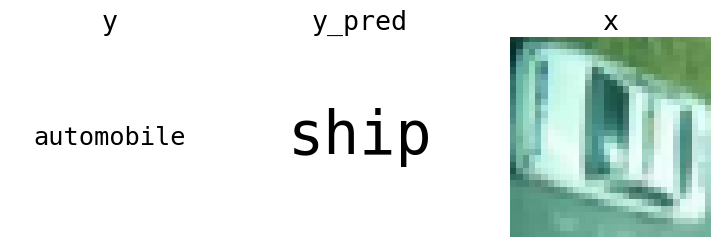

In [4]:
data_idx = 10380

class_map = {v: k for k, v in label_mapping.items()}
true_key = np.array([class_map[train_data[data_idx]['y'].item()]])

data = pipeline.transform(train_data[data_idx], mode='test')
y_pred = tf.argmax(model(data['x']), axis=-1).numpy().item()
pred_key = np.array([class_map[y_pred]])

images = fe.util.ImgData(y=true_key, y_pred=pred_key, x=np.expand_dims(train_data[data_idx]["x"], 0))
fig = images.paint_figure()
plt.show()

So we've got a (sideways) image of a car, but the network is probably looking at blue/green tint of the image and deciding that the image is a ship. It might also be confused by the angle/rotation of the image. If you're trying to expand your dataset this could provide some useful information about what sort of images you might need to collect in order to get a more robust network. You could also try some hue-shift and rotation data augmentation to correct for this.